In [115]:
list.of.packages <- c("tensorflow","keras","purrr","dplyr", "plotly","dataPreparation")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)

library(tensorflow)
library(keras)
library(dataPreparation)

library(readr)
library(knitr)
library(magrittr)
library(purrr)
library(ggplot2)
library(plotly)
library(dplyr)


Installing package into ‘/home/iserina/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)
Loading required package: lubridate

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: stringr
Loading required package: Matrix
Loading required package: progress
dataPreparation 0.4.0
Type dataPrepNews() to see new features/changes/bug fixes.


Code sample illustrating building a model, creating predictions, and writing out a CSV suitable to submit to Kaggle

## Read in the training dataset:

In [111]:
wine.df <- read.csv('https://raw.githubusercontent.com/serivan/mldmlab/master/Datasets/Kaggle-Wine-train.csv', sep=",")
summary(wine.df)

       Id       fixed.acidity    volatile.acidity  citric.acid   
 Min.   :   2   Min.   : 4.200   Min.   :  0.08   Min.   :0.000  
 1st Qu.:1172   1st Qu.: 6.300   1st Qu.:  0.21   1st Qu.:0.270  
 Median :2362   Median : 6.800   Median :  0.27   Median :0.320  
 Mean   :2346   Mean   : 6.857   Mean   : 11.11   Mean   :0.335  
 3rd Qu.:3506   3rd Qu.: 7.300   3rd Qu.:  0.33   3rd Qu.:0.390  
 Max.   :4653   Max.   :14.200   Max.   :965.00   Max.   :1.000  
                NA's   :3        NA's   :4                       
 residual.sugar     chlorides      free.sulfur.dioxide total.sulfur.dioxide
 Min.   : 0.600   Min.   :  0.02   Min.   :  3.00      Min.   : 10         
 1st Qu.: 1.700   1st Qu.: 33.00   1st Qu.: 24.00      1st Qu.:108         
 Median : 5.400   Median : 42.00   Median : 34.00      Median :135         
 Mean   : 6.485   Mean   : 40.68   Mean   : 35.33      Mean   :139         
 3rd Qu.:10.000   3rd Qu.: 49.00   3rd Qu.: 46.00      3rd Qu.:168         
 Max.   :65.800 

### Set up factorial (categorical variables):

Set Quality variable to factor column.

In [112]:
wine.df$Quality <- as.factor(wine.df$Quality) 

## Preparing data

Using dataPreparation package, those sets will be
*    fast (since dataPreparation is based on data.table framework and uses some computational tricks)
*    easy (since those functions are packaged and handle most of the situations)
*    robust (since it has been extensivly tested)

The first thing to do, in order to make computation fast, would be to check and filter useless variables:
*    Constant variables
*    Variables that are in double (for example col1 == col2)
*    Variables that are exact bijections (for example col1 = A, B, B, A and col2 = 1, 2, 2, 1)


In [117]:
constant_cols <- whichAreConstant(wine.df)
double_cols <- whichAreInDouble(wine.df)
bijections_cols <- whichAreBijection(wine.df)

[1] "whichAreConstant: it took me 0.01s to identify 0 constant column(s)"
[1] "whichAreInDouble: it took me 0.01s to identify 0 column(s) to drop."
[1] "whichAreBijection: it took me 0.21s to identify 0 column(s) to drop."


In [120]:

row.has.na <- apply(wine.df,1, function(x){any(is.na(x))})
wine.df <- wine.df[!row.has.na,]
head(wine.df)

Id,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,Quality
3940,6.4,0.39,0.21,1.2,41,35,136,0.99225,3.15,0.46,10.2,0
1655,7.5,305.00,0.40,18.9,59,44,170,1.00000,2.99,0.46,9.0,0
1867,6.3,0.28,0.30,3.1,39,24,115,0.99420,3.05,0.43,8.6,0
4476,7.4,0.18,0.30,10.4,45,44,174,0.99660,3.11,0.57,9.7,1
453,6.9,0.20,0.36,1.5,31,38,147,0.99310,3.35,0.56,11.0,1
3297,6.7,0.16,0.34,1.6,26,27,109,0.99340,3.34,0.58,10.1,1


In [130]:
train<-wine.df %>% select(-Id, -Quality)
train_y<-to_categorical(as.matrix(wine.df %>% select(Quality)))

### Scaling

Most machine learning algorithm rather handle scaled data instead of unscaled data.

To perform scaling (meaning setting mean to 0 and standard deviation to 1), function fastScale is available.

Since it is highly recommended to apply same scaling on train and test, you should compute the scales first using the function build_scales:

In [131]:
scales <- build_scales(dataSet = train, cols = colnames(data), verbose = TRUE)
print(scales)

[1] "build_scales: I will compute scale on  11 numeric columns."
[1] "build_scales: it took me: 0s to compute scale for 11 numeric columns."
$fixed.acidity
$fixed.acidity$mean
[1] 6.855771

$fixed.acidity$sd
[1] 0.8381437


$volatile.acidity
$volatile.acidity$mean
[1] 11.1544

$volatile.acidity$sd
[1] 67.27057


$citric.acid
$citric.acid$mean
[1] 0.3347216

$citric.acid$sd
[1] 0.1192347


$residual.sugar
$residual.sugar$mean
[1] 6.474768

$residual.sugar$sd
[1] 5.105248


$chlorides
$chlorides$mean
[1] 40.65829

$chlorides$sd
[1] 25.15562


$free.sulfur.dioxide
$free.sulfur.dioxide$mean
[1] 35.37166

$free.sulfur.dioxide$sd
[1] 16.50671


$total.sulfur.dioxide
$total.sulfur.dioxide$mean
[1] 138.9914

$total.sulfur.dioxide$sd
[1] 42.12042


$density
$density$mean
[1] 62.06375

$density$sd
[1] 238.6308


$pH
$pH$mean
[1] 3.185815

$pH$sd
[1] 0.1502064


$sulphates
$sulphates$mean
[1] 0.4888776

$sulphates$sd
[1] 0.1129795


$alcohol
$alcohol$mean
[1] 10.49531

$alcohol$sd
[1] 1.228179




In [132]:
train_x <- as.matrix(fastScale(dataSet = train, scales = scales, verbose = TRUE))
head(train_x)

[1] "fastScale: I will scale 11 numeric columns."
[1] "fastScale: it took me: 0s to scale 11 numeric columns."


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
-0.54378680,-0.1600165,-1.04601712,-1.0332051,0.0135840,-0.02251598,-0.07102123,-0.2559246,-0.2384383,-0.2556005,-0.2404442
0.76863736,4.3681153,0.54747822,2.4338156,0.7291299,0.52271676,0.73618812,-0.2558921,-1.3036391,-0.2556005,-1.2175009
-0.66309808,-0.1616517,-0.29120354,-0.6610390,-0.0659211,-0.68891154,-0.56959171,-0.2559164,-0.9041888,-0.5211354,-1.5431864
0.64932607,-0.1631382,-0.29120354,0.7688622,0.1725942,0.52271676,0.83115393,-0.2559064,-0.5047385,0.7180277,-0.6475511
0.05276964,-0.1628409,0.21200552,-0.9744420,-0.3839415,0.15922827,0.19013474,-0.2559210,1.0930627,0.6295160,0.4109269
-0.18585294,-0.1634355,0.04426916,-0.9548543,-0.5827043,-0.50716729,-0.71204042,-0.2559198,1.0264876,0.8065393,-0.3218656


Please check for errors

## Ensure everyone gets the same model and train:

* Set a seed for reproducibility.
* Create the simple machine learning model with keras.

In [133]:
set.seed(1)     


In [160]:
model = keras_model_sequential() 


model %>% 
  layer_dense(units = 20,  kernel_initializer = "uniform", activation = 'relu', input_shape = c(11)) %>% 
#  layer_dropout(rate = 0.3) %>% 
  layer_dense(units = 10, kernel_initializer = "uniform", activation = 'relu') %>%
#  layer_dropout(rate = 0.2) %>%
  layer_dense(units = 2, kernel_initializer = "uniform", activation = 'sigmoid')

model %>% compile(
  loss = "binary_crossentropy",
  optimizer = optimizer_rmsprop(),
#    optimizer = "adam", 
  metrics = c('accuracy')
)

history <- model %>% fit(
  train_x,train_y,
  epochs = 20, 
 #batch_size = 250, 
  validation_split = 0.3
)

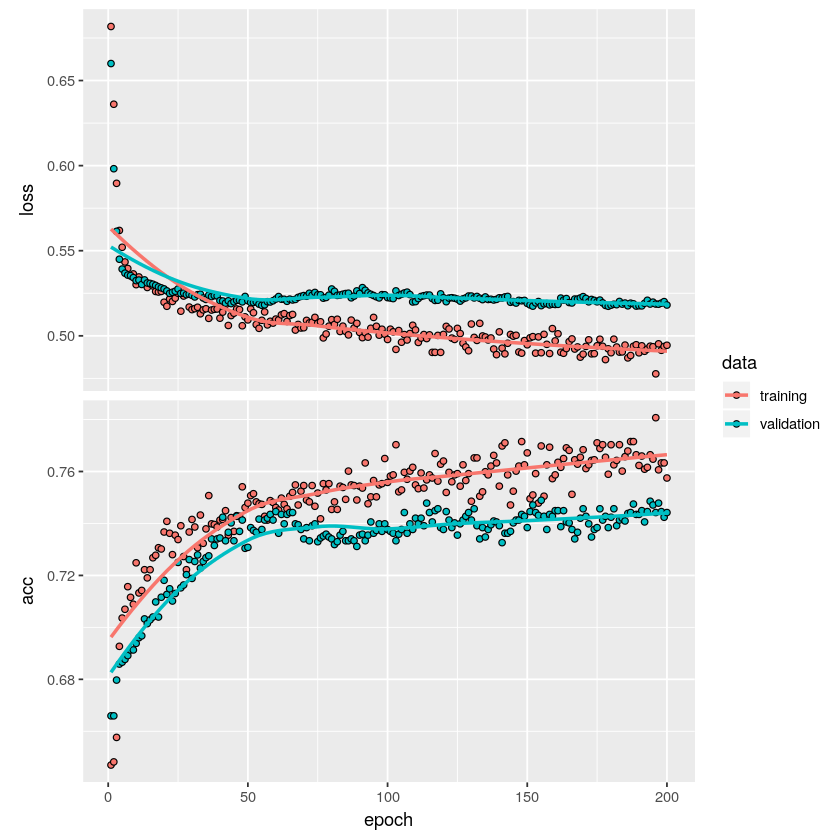

In [158]:
#Next, we evaluate the model and submit.

plot(history)

In [155]:
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_122 (Dense)                   (None, 20)                      240         
________________________________________________________________________________
dropout_14 (Dropout)                (None, 20)                      0           
________________________________________________________________________________
dense_123 (Dense)                   (None, 10)                      210         
________________________________________________________________________________
dense_124 (Dense)                   (None, 2)                       22          
Total params: 472
Trainable params: 472
Non-trainable params: 0
________________________________________________________________________________


In [159]:
eval=model %>% evaluate(train_x, train_y)
eval

$loss
[1] 0.4882454

$acc
[1] 0.7650812

## Working with the test data:

* Read the test.csv file and setting stringsAsFactors as FALSE.
* Convert Quality variable into factor column.

In [147]:
wine.test <- read.csv("https://raw.githubusercontent.com/serivan/mldmlab/master/Datasets/Kaggle-Wine-test.csv", stringsAsFactors = FALSE) 
#wine.test$Quality <- as.factor(wine.test$Quality) 
test<-wine.test %>% select(-Id)
test_x <- as.matrix(fastScale(dataSet = test, scales = scales, verbose = TRUE))


[1] "fastScale: I will scale 11 numeric columns."
[1] "fastScale: it took me: 0s to scale 11 numeric columns."


## Create predictions:

* Create a prediction using predict function.

In [148]:
preds <-model %>% predict_classes(test_x) 
head(preds)

[1] 1 1 1 1 1 1

## Preparing for submission:

* Create dataframe for submission
* Write out a .CSV suitable for Kaggle submission

In [104]:
submission <- data.frame(Id = wine.test$Id,
                         Quality = preds)   
write.csv(submission, file = "../MySubmission.csv", row.names = FALSE) 

In [102]:
list.files(path = ".")

[1] "Datasets"                                                     
 [2] "How_to_submit_prediction_to_Kaggle_in_Python.ipynb"           
 [3] "How_to_submit_prediction_to_Kaggle_in_Python.py"              
 [4] "How_to_submit_prediction_to_Kaggle_in_R_with_Keras.ipynb"     
 [5] "How_to_submit_prediction_to_Kaggle_in_R_with_Keras.R"         
 [6] "How_to_submit_prediction_to_Kaggle_in_R.ipynb"                
 [7] "How_to_submit_prediction_to_Kaggle_in_R.R"                    
 [8] "Install_R_notebook.ipynb"                                     
 [9] "ISRL-Lab01.Rmd"                                               
[10] "ISRL-Lab02-LinearRegressioninPython.ipynb"                    
[11] "ISRL-Lab02-LinearRegressioninR.ipynb"                         
[12] "ISRL-Lab02.py"                                                
[13] "ISRL-Lab02.Rmd"                                               
[14] "ISRL-Lab03-K-NearestNeighborsinPython.ipynb"                  
[15] "ISRL-Lab03-K-NearestNeighborsinR.ipynb"                       
[16] "ISRL-Lab03.py"                                                
[17] "ISRL-Lab03.Rmd"                                               
[18] "ISRL-Lab04-LogisticRegressioninPython.ipynb"                  
[19] "ISRL-Lab04-LogisticRegressioninR.ipynb"                       
[20] "ISRL-Lab04.py"                                                
[21] "ISRL-Lab04.Rmd"                                               
[22] "ISRL-Lab05-LDAandQDAinPython.ipynb"                           
[23] "ISRL-Lab05-LDAandQDAinR.ipynb"                                
[24] "ISRL-Lab05.py"                                                
[25] "ISRL-Lab05.Rmd"                                               
[26] "ISRL-Lab07-Cross-ValidationandBootstrapinPython.ipynb"        
[27] "ISRL-Lab07-Cross-ValidationandBootstrapinR.ipynb"             
[28] "ISRL-Lab07.Rmd"                                               
[29] "ISRL-Lab08-SubsetSelectioninPython.ipynb"                     
[30] "ISRL-Lab08-SubsetSelectioninR.ipynb"                          
[31] "ISRL-Lab08.py"                                                
[32] "ISRL-Lab08.Rmd"                                               
[33] "ISRL-Lab09-LinearModelSelectioninPython.ipynb"                
[34] "ISRL-Lab09-LinearModelSelectioninR.ipynb"                     
[35] "ISRL-Lab09.py"                                                
[36] "ISRL-Lab09.Rmd"                                               
[37] "ISRL-Lab10-RidgeRegressionandtheLassoinPython.ipynb"          
[38] "ISRL-Lab10-RidgeRegressionandtheLassoinR.ipynb"               
[39] "ISRL-Lab10.py"                                                
[40] "ISRL-Lab10.Rmd"                                               
[41] "ISRL-Lab11-PCRandPLSRegressioninPython.ipynb"                 
[42] "ISRL-Lab11-PCRandPLSRegressioninR.ipynb"                      
[43] "ISRL-Lab11.py"                                                
[44] "ISRL-Lab11.Rmd"                                               
[45] "ISRL-Lab12-PolynomialRegressionandStepFunctionsinPython.ipynb"
[46] "ISRL-Lab12-PolynomialRegressionandStepFunctionsinR.ipynb"     
[47] "ISRL-Lab12.py"                                                
[48] "ISRL-Lab12.Rmd"                                               
[49] "ISRL-Lab13-SplinesandGAMsinR.ipynb"                           
[50] "ISRL-Lab13-SplinesinPython.ipynb"                             
[51] "ISRL-Lab13.py"                                                
[52] "ISRL-Lab13.Rmd"                                               
[53] "ISRL-Lab14-DecisionTreesinPython.ipynb"                       
[54] "ISRL-Lab14-DecisionTreesinR.ipynb"                            
[55] "ISRL-Lab14.py"                                                
[56] "ISRL-Lab14.Rmd"                                               
[57] "ISRL-Lab15-SupportVectorMachinesinPython.ipynb"               
[58] "ISRL-Lab15-SupportVectorMachinesinR.ipynb"                    